# Chatbot Seq2Seq con Mecanismo de Atención

Los chatbots son programas que generan respuestas basadas en una entrada dada para simular conversaciones humanas vía texto o voz. Estos programas son diseñados para simular las interacciones humanas, y sus aplicaciones van desde los servicios personalizados, sugerencias de productos, hasta los asistentes personales.


La construcción de un chatbot, parte del problema de generar texto a partir de una entrada. Durante los últimos años se han realizado diferentes investigaciones en el campo de Aprendizaje profundo para solucionar este problema. Una arquitectura sobresaliente es la de encoder-decoder. Sin embargo, como esta estructura el encoder resume la información de toda la entrada en un solo vector, antes de pasarlo al decoder, se pierde la influencia de algunas palabras de la entrada y su contexto. Por lo tanto un método de mejora planteado es el uso de un mecanismo de atención. Nuestro objetivo es construir un chatbot en español basado en un modelo seq2seq con un mecanismo de atención, y evaluar los resultados utilizando diferentes configuraciones del modelo. Para la implemetación usaremos Python y librerías especializadas para esta tarea como Torch usando tensores.   

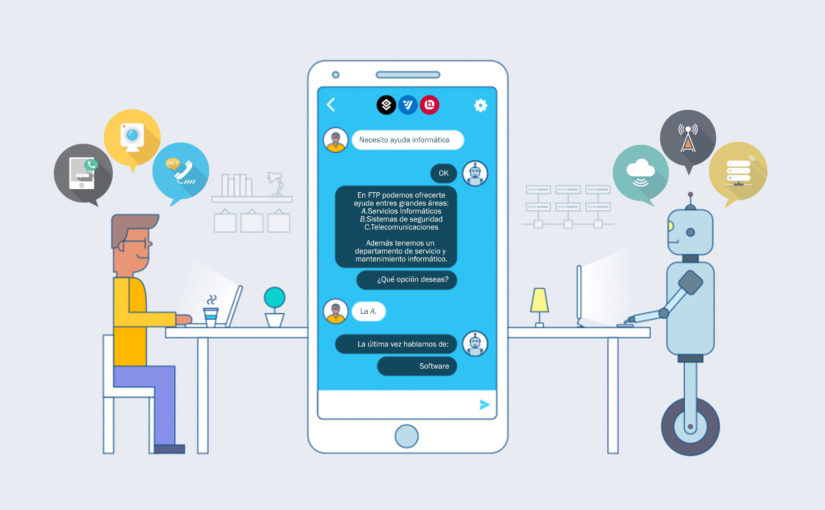

# MODELO



## PREPARACIÓN DE LA DATA

El proceso de preparación de la data para el modelo de entrenamiento consiste en obtener listas de vectores, cada vector contiene la sentencia de pregunta y la sentencia de respuesta. En este proceso también hacemos un mapeo de cada palabra a índices y de índice palabras, esto se almacenará en diccionarios, además de llevar el conteo de cuántas veces una palabra se repite. Esto nos permitirá obtener el índice que le corresponde a cada palabra y viceversa.

Mounted at /gdrive
/gdrive/.shortcut-targets-by-id/1ccQ0NRVtxcnMDQHOrldbGFQDfXPWk9Jj/iA


In [ ]:
import torch
from torch.jit import script
import torch.nn as nn
import random
import re
import unicodedata
from io import open
import itertools
from tqdm import tqdm

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

MAX_LENGTH = 20 # Cantidad de palabras máxima por cada sentencia

In [ ]:
# Definiciones:
#   Linea: Pares de sentencias separadas por un padding \t
#   Sentencia: Texto de la pregunta o la respuesta.
#   Par: Un vector, cada vector contiene dos senticias: pregunta y la respuesta

PAD_token = 0  # Token para rellenar las sentencias con una cantidad menor a MAX_LENGTH
SOS_token = 1  # Token que indica el inicio de la sentencia
EOS_token = 2  # Token que indica el final de la sentencia

# Objeto Voc: 
#   Procesará cada sentencia de cada línea. 
#   Nos ayudará a generar una mapeo de cada palabra a indices (números)
#   lo que permitirá obtener el índice que corresponde a cada palabra, la palabra que le
#   corresponde a cada índice y la cantidad de veces que una palabra se repíte.
class Voc:
    def __init__(self, name):
        self.name = name
        self.trimmed = False
        self.word2index = {"PAD":PAD_token , "SOS":SOS_token , "EOS":EOS_token }
        self.word2count = {}
        self.index2word = {PAD_token: "PAD", SOS_token: "SOS", EOS_token: "EOS"}
        self.num_words = 3  # Los 3 tokens inicializados SOS, EOS, PAD

    def agregarSentencia(self, sentence):
        for word in sentence.split(' '):
            self.agregarPalabra(word)

    def agregarPalabra(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.num_words
            self.word2count[word] = 1
            self.index2word[self.num_words] = word
            self.num_words += 1
        else:
            self.word2count[word] += 1

    def indiceDeSentencia(self, sentencia):
        return [self.word2index[word] for word in sentencia.split(' ')] + [EOS_token]

    def sentenciaDeIndice(self, indice):
        return [self.index2word[idx] for idx in indice]

    # Remueve las palabras que se repiten menos de una cierta cantidad de veces
    def trim(self, min_count):
        if self.trimmed:
            return
        self.trimmed = True

        keep_words = []

        for k, v in self.word2count.items():
            if v >= min_count:
                keep_words.append(k)

        print('keep_words {} / {} = {:.4f}'.format(
            len(keep_words), len(self.word2index), len(keep_words) / len(self.word2index)
        ))

        # Reinicializamos los diccionarios
        self.word2index = {"PAD":PAD_token , "SOS":SOS_token , "EOS":EOS_token }
        self.word2count = {}
        self.index2word = {PAD_token: "PAD", SOS_token: "SOS", EOS_token: "EOS"}
        self.num_words = 3 # Los 3 tokens inicializados SOS, EOS, PAD

        for word in keep_words:
            self.agregarPalabra(word)

In [ ]:
# Función que normalizará cada sentencia
def unicodeToAscii(s):
    return ''.join(
        # c for c in unicodedata.normalize('NFD', s) # Normalizará y eliminará las tildes y la ñ
        c for c in unicodedata.normalize('NFC', s) # Normalizará y mantiene las tildes y la ñ
        if unicodedata.category(c) != 'Mn'
    )

# Normalizamos cada sentencia
def normalizeString(s):
    s = unicodeToAscii(s.lower().strip()) # Normalizamos y pasamos todas las letras a minúsculas
    # Pasamos cada sentencia a minúsculas, removemos los espacios y carácteres que no son letras excluyendo los números
    s = re.sub(r"([.¡!¿?])", r" \1", s)  # Mantenemos los signos interrogación y exclamación de apertura y cierre
    s = re.sub(r"[^A-zÁ-ú.¡!¿?0-9]+", r" ", s) # Mantenemos las tildes y números

    # s = re.sub(r"[^A-z.¡!¿?0-9]+", r" ", s) # Elimina tildes
    s = re.sub(r"\.", r"", s)
    s = re.sub(r"\¿\s+", r"¿", s) # Elimina espacios alrededor del signo de interrogación
    s = re.sub(r"\s+\?", r"?", s) # Elimina espacios alrededor del signo de interrogación
    s = re.sub(r"\¡\s", r"¡", s) # Elimina espacios alrededor del signo de exclamación
    s = re.sub(r"\!\s", r"!", s) # Elimina espacios alrededor del signo de exclamación
    s = re.sub(r"\s+", r" ", s).strip() # Elimina los espacios demás
    return s



# Leemos las lineas del archivo y devolvemos los pares y un objeto Voc
def readVocs(datafile, corpus_name):
    print("Leyendo líneas...")
    # Leemos el archivo y devuelve una lista de líneas
    lines = open(datafile, encoding='utf-8').\
        read().strip().split('\n')
    # Dividimos cada linea en pares, normaliza normalizando cada sentencia
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]
    voc = Voc(corpus_name)
    # Devuelve el objeto vocabulario y los pares
    return voc, pairs

# Retorna True si ambas sentencias en el par tienen una cantidad de palabras menores que MAX_LENGTH
def filtrarPar(p):
    # Las sentencias de entrada, necesitamos un espacio para el token SOS
    return len(p[0].split(' ')) < MAX_LENGTH and len(p[1].split(' ')) < MAX_LENGTH

# Filtra los pares usando la función filtrarPar
def filtrarPares(pairs):
    return [pair for pair in pairs if filtrarPar(pair)]

# Usando las funciones definidas arriba generamos el diccionario que mapea de palabras a índices
# devolverá el objeto voc y la lista de pares
def loadPrepareData(corpus, corpus_name, datafile, save_dir):
    print("Empieza la preparación de la data ...")
    voc, pairs = readVocs(datafile, corpus_name)
    print("Se leyó {!s} pares de sentencias".format(len(pairs)))
    pairs = filtrarPares(pairs)
    print("Filtrado {!s} pares de sentencias".format(len(pairs)))
    print("Contando las palabras...")

    for pair in pairs:
        # Agregamos cada sentencia al objeto Voc para hacer el mapeo
        voc.agregarSentencia(pair[0])
        voc.agregarSentencia(pair[1])
        
    print("Cantidad total de palabras:", voc.num_words)
    
    
    return voc, pairs



save_dir = "./"
datafile = "../Data/METALW.txt"
corpus = "./"
corpus_name = "dataf_s2s"
voc, pairs = loadPrepareData(corpus, corpus_name, datafile, save_dir)

# Imprimimos una muestra de la data para verificar su estructura
print("\npares:")

for pair in pairs[:10]:
    print(pair)

# Fuente: https://pytorch.org/tutorials/beginner/chatbot_tutorial.html?highlight=chatbot%20tutorial

Empieza la preparación de la data ...
Leyendo líneas...
Read 319593 sentence pairs
Trimmed to 294593 sentence pairs
Contando las palabras...
Cantidad total de palabras: 61038

pairs:
['hola ¿en qué puedo ayudarle?', 'sí']
['sí', '¿cómo puedo ser de ayuda?']
['¿cómo puedo ser de ayuda?', 'quiero saber sobre la política que tengo']
['quiero saber sobre la política que tengo', 'bien ¿puedo conseguir tu nombre por favor?']
['bien ¿puedo conseguir tu nombre por favor?', '¿cubre los daños causados por el agua?']
['¿cubre los daños causados por el agua?', 'necesito su nombre y número de póliza para acceder a su póliza por favor']
['hola ¿en qué puedo ayudarle?', 'tengo una pregunta sobre mi política']
['tengo una pregunta sobre mi política', 'seguro ¿puedes decirme tu número de póliza?']
['seguro ¿puedes decirme tu número de póliza?', '3425512']
['3425512', 'bien tengo tu póliza aquí ¿cuál es tu pregunta?']


La clase Dataset se va encargar de convertir en tensores la entrada y salida del conjunto de entrenamiento, y completar con la palabra clave 'PAD' a la entrada y salida si su longitud es menor a la longitud maxima establecida

In [ ]:
# comprobar si el entorno usa gpu o cpu
device = "cuda" if torch.cuda.is_available() else "cpu"

class Dataset(torch.utils.data.Dataset):
    def __init__(self, entrada_voc, salida_voc, pares, max_length):
        self.entrada_voc = entrada_voc
        self.salida_voc = salida_voc
        self.pares = pares
        self.max_length = max_length
    
    def __len__(self):
        return len(self.pares)
        
    def __getitem__(self, ind): 
        # la entrada y salida se convierte en tensores       
        entrada = torch.tensor(self.entrada_voc.indiceDeSentencia(self.pares[ind][0]), device=device, dtype=torch.long)
        salida = torch.tensor(self.salida_voc.indiceDeSentencia(self.pares[ind][1]), device=device, dtype=torch.long)
        # metemos padding a todas las frases hasta completar la longitud maxima (MAX_LENGTH)
        return torch.nn.functional.pad(entrada, (0, self.max_length - len(entrada)), 'constant', self.entrada_voc.word2index['PAD']), \
            torch.nn.functional.pad(salida, (0, self.max_length - len(salida)), 'constant', self.salida_voc.word2index['PAD'])

In [ ]:
dataset = {
    'train': Dataset(voc, voc, pairs, max_length=MAX_LENGTH),
}

len(dataset['train'])

294593

In [ ]:
entrada, salida = dataset['train'][100]
entrada.shape, salida.shape

(torch.Size([20]), torch.Size([20]))

In [ ]:
voc.sentenciaDeIndice(entrada.tolist()), voc.sentenciaDeIndice(salida.tolist())

(['¿',
  'cual',
  'es',
  'mi',
  'prima',
  'de',
  'seguro',
  'medico',
  '?',
  'EOS',
  'PAD',
  'PAD',
  'PAD',
  'PAD',
  'PAD',
  'PAD',
  'PAD',
  'PAD',
  'PAD',
  'PAD',
  'PAD',
  'PAD',
  'PAD',
  'PAD',
  'PAD'],
 ['sus',
  '5',
  'dolares',
  'al',
  'mes',
  'EOS',
  'PAD',
  'PAD',
  'PAD',
  'PAD',
  'PAD',
  'PAD',
  'PAD',
  'PAD',
  'PAD',
  'PAD',
  'PAD',
  'PAD',
  'PAD',
  'PAD',
  'PAD',
  'PAD',
  'PAD',
  'PAD',
  'PAD'])

## Modelo

Encoder



In [ ]:
class Encoder(torch.nn.Module):
  def __init__(self, longitud_entrada, longitud_embedding=100, longitud_oculta=100, n_capas=2):
    super().__init__()
    # Inicializacion de la longitud del estado oculto
    self.longitud_oculta = longitud_oculta
    # Inicializacion del embedding
    self.embedding = torch.nn.Embedding(longitud_entrada, longitud_embedding)
    # Inicializacion de la red GRU
    self.gru = torch.nn.GRU(longitud_embedding, longitud_oculta, num_layers=n_capas, batch_first=True)

  # Definicion del forward, retorna la salida y el estado oculto
  def forward(self, oraciones_entrada):
    embedded = self.embedding(oraciones_entrada)
    salidas, oculta = self.gru(embedded)
    return salidas, oculta

Decoder

In [ ]:
class AtencionDecoder(torch.nn.Module):
  def __init__(self, longitud_entrada, longitud_embedding=100, longitud_oculta=100, n_layers=2, longitud_maxima=MAX_LENGTH):
    super().__init__()
    # Inicializacion del embedding
    self.embedding = torch.nn.Embedding(longitud_entrada, longitud_embedding)
    # Inicializacion de la red GRU
    self.gru = torch.nn.GRU(longitud_embedding, longitud_oculta, num_layers=n_layers, batch_first=True)
    # Define una transformacion lineal para la salida del decoder
    self.out = torch.nn.Linear(longitud_oculta, longitud_entrada)

    # Define la transformacion lineal para el calculo del vector de atencion
    self.atencion = torch.nn.Linear(longitud_oculta + longitud_embedding, longitud_maxima)
    # Define la transformacion lineal para combinar el vector de atencion con el estado oculto del encoder
    self.combinar_atencion = torch.nn.Linear(longitud_oculta * 2, longitud_oculta)

  # Definicion del forward, retorna la salida, el estado oculto, y los pesos del vector de pesos de atencion
  def forward(self, palabras_entrada, oculta, salidas_encoder):
    embedded = self.embedding(palabras_entrada)
    pesos_atencion = torch.nn.functional.softmax(self.atencion(torch.cat((embedded.squeeze(1), oculta[0]), 1)))
    atencion_aplicada = torch.bmm(pesos_atencion.unsqueeze(1), salidas_encoder)
    # Concatena el embedding con el vector de atencion
    salida = torch.cat((embedded.squeeze(1), atencion_aplicada.squeeze(1)), 1)
    salida = self.combinar_atencion(salida)
    salida = torch.nn.functional.relu(salida)
    salida, oculta = self.gru(salida.unsqueeze(1), oculta)
    salida = self.out(salida.squeeze(1))
    return salida, oculta, pesos_atencion

In [ ]:
# Creamos instancias del encoder y decoder
encoder = Encoder(longitud_entrada=voc.num_words,  longitud_embedding=300, longitud_oculta=300)
decoder = AtencionDecoder(longitud_entrada=voc.num_words, longitud_embedding=300, longitud_oculta=300))

## Entrenamiento

In [ ]:
dataloader = {
    'train': torch.utils.data.DataLoader(dataset['train'], batch_size=512, shuffle=True )
}

entrada, salida = next(iter(dataloader['train']))
entrada.shape, salida.shape

(torch.Size([512, 20]), torch.Size([512, 20]))

In [ ]:
def entrenamiento(encoder, decoder, epochs=10):
    # manda a la cuda el encoder y decoder
    encoder.to(device)
    decoder.to(device)
    # construccion del optimizador en el encoder y decoder con 
    # learning rate = 0.001
    encoder_optimizador = torch.optim.Adam(encoder.parameters(), lr=1e-3)
    decoder_optimizador = torch.optim.Adam(decoder.parameters(), lr=1e-3)
    # función de perdida
    criterion = torch.nn.CrossEntropyLoss()
    for epoch in range(1, epochs+1):
        encoder.train()
        decoder.train()
        train_perdida = []

        batches = dataloader['train']
        pos_batch = 0
        for batch in batches:
            entrada_sentencia, salida_sentencia = batch
            base = entrada_sentencia.shape[0]
            perdida = 0
            # estableciendo en 0 las gradientes del encoder y decoder
            encoder_optimizador.zero_grad()
            decoder_optimizador.zero_grad()
            # obteniendo el último estado oculto del encoder
            encoder_salida, estado_oculto = encoder(entrada_sentencia)
            # calculando las salidas del decoder
            decoder_entrada = torch.tensor([[voc.word2index['SOS']] for b in range(base)], device=device)
            for i in range(salida_sentencia.shape[1]):
                salida, estado_oculto, peso_atencion = decoder(decoder_entrada, estado_oculto, encoder_salida)
                perdida += criterion(salida, salida_sentencia[:, i].view(base))
                # el siguiente entrada será la palabra que se predice
                decoder_entrada = torch.argmax(salida, axis=1).view(base, 1)
            # optimizacion
            perdida.backward()
            encoder_optimizador.step()
            decoder_optimizador.step()
            train_perdida.append(perdida.item())
            # visualisación del error en el ultimo batch
            if pos_batch == len(batches)-1:
                print(f'Epoch {epoch}/{epochs} loss {np.mean(train_perdida):.5f}')
            pos_batch +=1

## Fases del entrenamiento

El modelo se ha entrenado en 4 etapas, debido al tiempo que tarda. Al finalizar cada fase se guarda el modelo para poder poder cargarlo y entrenar en la siguiente etapa.

### Etapa 1(despues de ejecutar 65 épocas)

In [ ]:
entrenamiento(encoder, decoder, epochs=15)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  del sys.path[0]


Epoch 1/15 loss 32.87621
Epoch 2/15 loss 32.27753
Epoch 3/15 loss 32.18466
Epoch 4/15 loss 32.12364
Epoch 5/15 loss 31.98159
Epoch 6/15 loss 31.87261
Epoch 7/15 loss 31.78031
Epoch 8/15 loss 31.70202
Epoch 9/15 loss 31.59548
Epoch 10/15 loss 31.49525
Epoch 11/15 loss 31.40330
Epoch 12/15 loss 31.32785
Epoch 13/15 loss 31.28816
Epoch 14/15 loss 31.21154
Epoch 15/15 loss 31.07752


### Etapa 2(+15 épocas)

In [ ]:
entrenamiento(encoder, decoder, epochs=15)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  del sys.path[0]


Epoch 1/15 loss 31.35947
Epoch 2/15 loss 30.86283
Epoch 3/15 loss 30.78868
Epoch 4/15 loss 30.78238
Epoch 5/15 loss 30.69439
Epoch 6/15 loss 30.70745
Epoch 7/15 loss 30.55892
Epoch 8/15 loss 30.46360
Epoch 9/15 loss 30.37020
Epoch 10/15 loss 30.32382
Epoch 11/15 loss 30.23739
Epoch 12/15 loss 30.17890
Epoch 13/15 loss 30.12223
Epoch 14/15 loss 30.05793
Epoch 15/15 loss 29.99916


### Etapa 3 (+10 épocas)

In [ ]:
entrenamiento(encoder, decoder, epochs=10)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  del sys.path[0]


Epoch 1/10 loss 30.29090
Epoch 2/10 loss 29.83321
Epoch 3/10 loss 29.86021
Epoch 4/10 loss 29.79514
Epoch 5/10 loss 29.80991
Epoch 6/10 loss 29.77412
Epoch 7/10 loss 29.72836
Epoch 8/10 loss 29.61074
Epoch 9/10 loss 29.45420
Epoch 10/10 loss 29.42460


## Guardar estado del modelo

In [ ]:
torch.save({'encoder':encoder.state_dict(),
            'decoder':decoder.state_dict()},
            'checkpoint-20ML-85ep-data-METALW-512bz-con-tildes-300em-300h.pt')

## Cargar el modelo

In [ ]:
encoder = Encoder(longitud_entrada=voc.num_words,  longitud_embedding=300, longitud_oculta=300).cuda()
decoder = AtencionDecoder(longitud_entrada=voc.num_words,  longitud_embedding=300, longitud_oculta=300).cuda()
checkpoint = torch.load('checkpoint-20ML-85ep-data-METALW-512bz-con-tildes-300em-300h.pt')
encoder.load_state_dict(checkpoint['encoder'])
decoder.load_state_dict(checkpoint['decoder'])

<All keys matched successfully>

## Predicción de la secuencia de salida

El siguiente método nos permite convertir un texto a tensor en base a un vocabulario voc, además añadimos el caracter especial al final del tensor, para indicar fin de la secuencia

In [ ]:
def convertirATensor(oracion, voc):
     #convertimos en una lista de palabras la oración, y le añadimos el símbolo EOS al final 
     listaDePalabras = [voc.word2index[palabra] for palabra in oracion.strip().split(' ')] + [EOS_token]
     
     #convertimos en tensor la lista de palabras
     salidaTensor = torch.tensor(listaDePalabras, device=device, dtype=torch.long)
     return torch.nn.functional.pad(salidaTensor,(0,MAX_LENGTH-len(salidaTensor)),'constant',voc.word2index['PAD'])  

Para predecir debemos convertir la oración de entrada en un tensor y pasar al encoder. Luego se toma la salida del encoder y se pasa al decoder para obtener uno a uno los terminos de la secuencia de salida.

In [ ]:
def predecir(secuencia_de_entrada):
    # obtenemos el último estado oculto del encoder
    encoder_salidas, oculto = encoder(secuencia_de_entrada.unsqueeze(0))
    
    # calculamos las salidas del decoder de manera recurrente
    decoder_entrada = torch.tensor([[voc.word2index['SOS']]], device=device)
    
    # inicializamos el vector de atención del decoder
    decoder_atencion = torch.zeros(MAX_LENGTH, MAX_LENGTH)

    # iteramos hasta que el decoder nos de el token <eos>
    salidas = []
    i = 0
    while True and i<MAX_LENGTH:
        salida, oculto, attn_pesos = decoder(decoder_entrada, oculto, encoder_salidas)
        i += 1
        decoder_entrada = torch.argmax(salida, axis=1).view(1, 1)
        salidas.append(decoder_entrada.cpu().item())
        if decoder_entrada.item() == voc.word2index['EOS']:
            break
    return voc.sentenciaDeIndice(salidas)

Ahora podemos probar el modelo, en base a una secuencia de entrada

In [ ]:
salidaTextual, salidaCodificada = predict(inputVar("¿ cuál es tu nombre ?",voc))

¿ cuál es tu nombre ?
[14438, 148, 52, 23, 24, 6570, 2]
encoder
decoder


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  del sys.path[0]


In [ ]:
print(salidaTextual)

['mi', 'nombre', 'es', 'bob', 'EOS']
